In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from cleaningScript import cleanDatav2 # I <3 encapsulation

In [2]:
#function to calculate metrics quickly
def printMetrics(testActualVal, predictions):
    print("MAE: ", sklearn.metrics.mean_absolute_error(testActualVal, predictions))
    print("RMSE: ", sklearn.metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", sklearn.metrics.r2_score(testActualVal, predictions))

In [3]:
route, direction = '84', 1

In [4]:
df = cleanDatav2(route, direction)

In [5]:
print(len(df),  "rows")
df.head(3)

345486 rows


,index,date,tripid,progrnumber,stopActualArr,journeytime,dwelltime,rain,temp,humidity,pressure
0,0,2018-01-01,5955785,1,36583,0,0,0.0,5.6,79,992.9
1,1,2018-01-01,5955785,2,36617,34,12,0.0,5.6,79,992.9
2,2,2018-01-01,5955785,3,36721,138,0,0.0,5.6,79,992.9


In [6]:
df['weekday'] = df.date.dt.weekday
df['month'] = df.date.dt.month
df['hour'] = (df.stopActualArr//3600)
df.head(3)

,index,date,tripid,progrnumber,stopActualArr,journeytime,dwelltime,rain,temp,humidity,pressure,weekday,month,hour
0,0,2018-01-01,5955785,1,36583,0,0,0.0,5.6,79,992.9,0,1,10
1,1,2018-01-01,5955785,2,36617,34,12,0.0,5.6,79,992.9,0,1,10
2,2,2018-01-01,5955785,3,36721,138,0,0.0,5.6,79,992.9,0,1,10


## Journey time vs Progrnumber

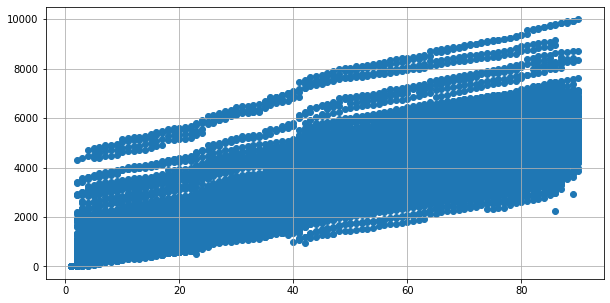

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(df.progrnumber, df.journeytime)
plt.grid()

Journey times are sometimes negative. Removing any stop from a journey that had a negative journey time anywhere as the whole trip could be offset

# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

dftmp = df[(df.journeytime <= 0) & (df.progrnumber > 1)]
df = df[~df['date'].isin(dftmp['date']) | ~df['tripid'].isin(dftmp['tripid'])]
print(len(df),  "rows")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

plt.figure(figsize=(10,5))
plt.scatter(df.progrnumber, df.journeytime)
plt.grid()

## Journey time vs Month

In [8]:
dfTotalJourney = df.groupby(['date','tripid']).max() #get the max journey time for a stop on a trip ,i.e. the last stop
dfTotalJourney

index  progrnumber  stopActualArr  journeytime  \
date       tripid                                                     
2018-01-01 5955785      85           86          41351         4768   
           5955787     255           89          51000         4788   
           5955789     427           86          60201         4337   
           5955791     600           86          70188         4768   
           5955793     771           86          79206         4279   
...                    ...          ...            ...          ...   
2018-10-27 8054816  347785           87          76935         5563   
           8059369  347232           87          28872         4862   
           8059371  347365           90          43511         4996   
           8059375  347637           87          68567         5332   
           8059377  347842           87          80754         5136   

                    dwelltime  rain  temp  humidity  pressure  weekday  month  \
date       tripid                                                               
2018-01-01 5955785        647   0.0   6.7        79     994.1        0      1   
           5955787        451   0.2   7.5        81     998.3        0      1   
           5955789        194   0.0   7.3        75    1001.9        0      1   
           5955791        214   0.0   5.7        81    1006.2        0      1   
           5955793        748   0.0   5.0        79    1008.5        0      1   
...                       ...   ...   ...       ...       ...      ...    ...   
2018-10-27 8054816        921   0.0   3.3        70    1026.2        5     10   
           8059369       1288   0.0   2.8        80    1022.5        5     10   
           8059371        442   0.0   7.2        64    1023.0        5     10   
           8059375        469   0.0   4.9        68    1025.1        5     10   
           8059377       1193   0.0   1.9        74    1026.3        5     10   

                    hour  
date       tripid         
2018-01-01 5955785    11  
           5955787    14  
           5955789    16  
           5955791    19  
           5955793    22  
...                  ...  
2018-10-27 8054816    21  
           8059369     8  
           8059371    12  
           8059375    19  
           8059377    22  

[4053 rows x 12 columns]

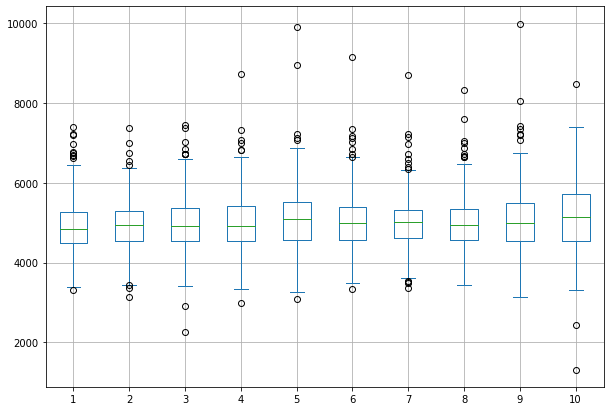

In [9]:
plt.rcParams["figure.figsize"] = (10, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('month').cumcount()).pivot('index','month','journeytime').plot(kind='box')
plt.grid()

some small variation in the boxplots. Doesn't look very promising but not reason enough to exclude yet

## Journey time vs Weekday

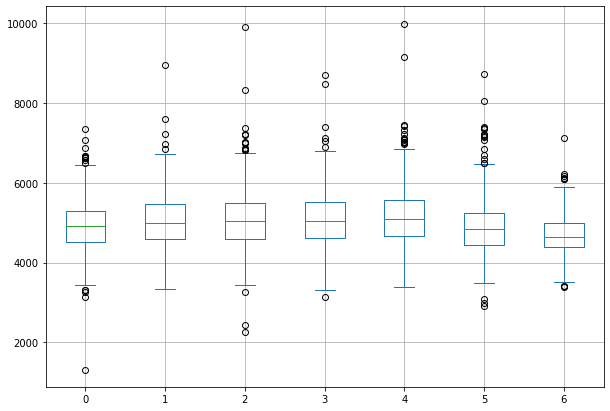

In [10]:
plt.rcParams["figure.figsize"] = (10, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('weekday').cumcount()).pivot('index','weekday','journeytime').plot(kind='box')
plt.grid()

more variation here for weekday, more promising particularly for the weekend

## Journey time vs Hour

In [11]:
dfTotalJourney.hour %= 24

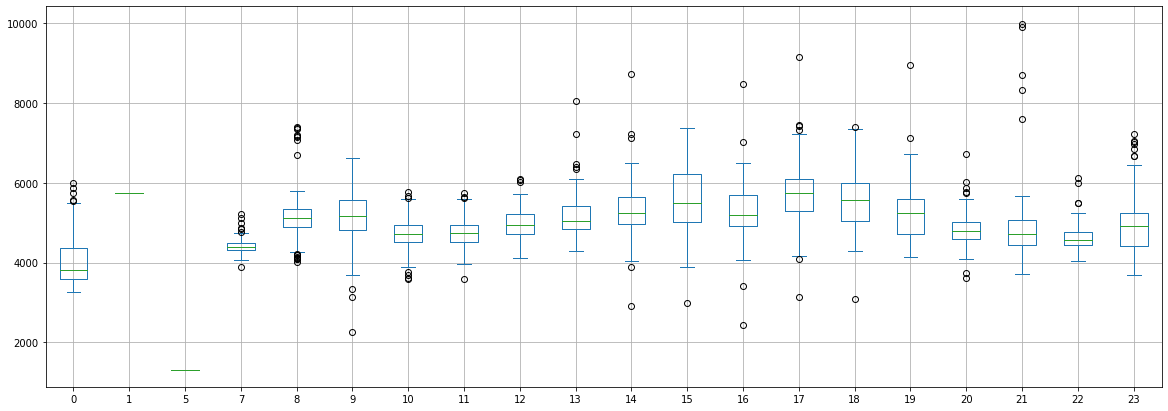

In [12]:
plt.rcParams["figure.figsize"] = (20, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('hour').cumcount()).pivot('index','hour','journeytime').plot(kind='box')
plt.grid()

some variation in the hour of the day the route finishes. appears to be cyclical, with 2 peaks and troughs. Maybe ausing some sort of trigonometric function or polynomial to model as well as having separate factors for each month.

## Journey time vs Rain

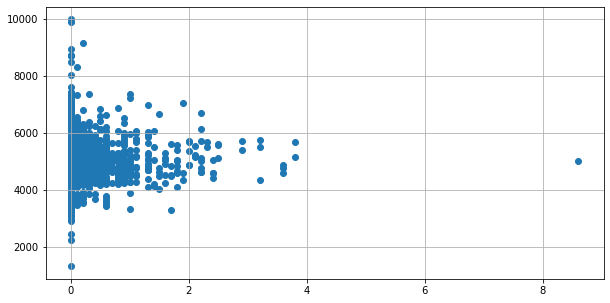

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.rain, dfTotalJourney.journeytime)
plt.grid()

looks like a normal distribution of journey times. The heavier rain is just clumped around the mean. This doesn't appear to have much predictive power.

## Journey time vs Temperature

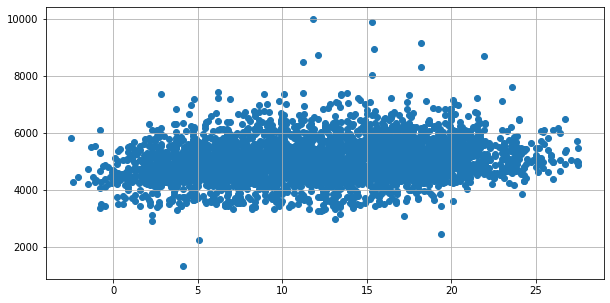

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.temp, dfTotalJourney.journeytime)
plt.grid()

looks like temperature doesn't have a correlation with the total journey time either, just clumped around the middle with no apparent relationship

## Journey time vs Humidity & Journey time vs Pressure

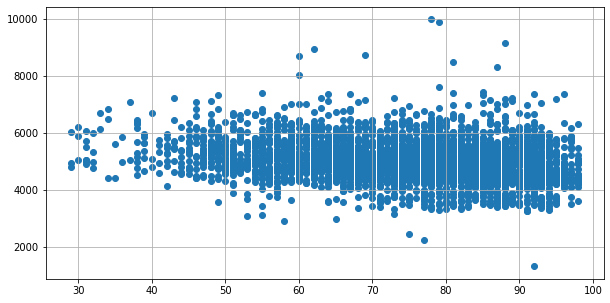

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.humidity, dfTotalJourney.journeytime)
plt.grid()

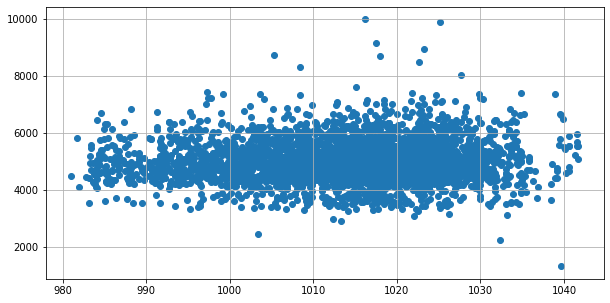

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.pressure, dfTotalJourney.journeytime)
plt.grid()

First plot is humidity and appears to have a slight negative relationship with journey time so will look to see if it's useful.

Second plot is pressure and doesn't appear to have any meaningful relationship to journey time. It's clumped aroun=d the centre like temperature

# Model for total trip time

In [17]:
dfTotalJourney.head(3)

index  progrnumber  stopActualArr  journeytime  dwelltime  \
date       tripid                                                               
2018-01-01 5955785     85           86          41351         4768        647   
           5955787    255           89          51000         4788        451   
           5955789    427           86          60201         4337        194   

                    rain  temp  humidity  pressure  weekday  month  hour  
date       tripid                                                         
2018-01-01 5955785   0.0   6.7        79     994.1        0      1    11  
           5955787   0.2   7.5        81     998.3        0      1    14  
           5955789   0.0   7.3        75    1001.9        0      1    16

In [18]:
#removing rain, temp, pressure as no correlation is apparent
#removing stopActualArr as journeytime is calculated from it
#removing journeytime as I am modelling the total journey
#dwelltime also removed as it is part of the journeytime and so can't be used to predict ahead of time
#keeping date and tripid for ID purposes
dfTotalJourney = dfTotalJourney.drop(columns = ['stopActualArr','rain','temp','pressure','progrnumber','dwelltime'])

In [19]:
dfTotalJourney.head(3)

index  journeytime  humidity  weekday  month  hour
date       tripid                                                     
2018-01-01 5955785     85         4768        79        0      1    11
           5955787    255         4788        81        0      1    14
           5955789    427         4337        75        0      1    16

In [20]:
dfTotalJourney.month = dfTotalJourney.month.astype('category')
dfTotalJourney.hour = dfTotalJourney.hour.astype('category')
dfTotalJourney.weekday = dfTotalJourney.weekday.astype('category')

In [21]:
monthlyDummies = pd.get_dummies(dfTotalJourney.month, prefix='m', drop_first=True)
hourlyDummies = pd.get_dummies(dfTotalJourney.hour,prefix='h', drop_first=True)
dailyDummies = pd.get_dummies(dfTotalJourney.weekday, prefix='d', drop_first=True)

In [22]:
dfTotalJourney = pd.concat([dfTotalJourney,monthlyDummies,hourlyDummies,dailyDummies], axis = 1)

In [23]:
dfTotalJourney.drop(columns=['month','hour','weekday'], inplace=True)

In [24]:
dfTotalJourney.head(3)

index  journeytime  humidity  m_2  m_3  m_4  m_5  m_6  \
date       tripid                                                           
2018-01-01 5955785     85         4768        79    0    0    0    0    0   
           5955787    255         4788        81    0    0    0    0    0   
           5955789    427         4337        75    0    0    0    0    0   

                    m_7  m_8  ...  h_20  h_21  h_22  h_23  d_1  d_2  d_3  d_4  \
date       tripid             ...                                               
2018-01-01 5955785    0    0  ...     0     0     0     0    0    0    0    0   
           5955787    0    0  ...     0     0     0     0    0    0    0    0   
           5955789    0    0  ...     0     0     0     0    0    0    0    0   

                    d_5  d_6  
date       tripid             
2018-01-01 5955785    0    0  
           5955787    0    0  
           5955789    0    0  

[3 rows x 37 columns]

In [25]:
for i in dfTotalJourney:
    dfTotalJourney[i] = dfTotalJourney[i].astype('int')

In [26]:
Xfeatures = dfTotalJourney.columns[dfTotalJourney.columns != 'journeytime']
Xfeatures = Xfeatures.drop(['humidity'])
X = dfTotalJourney[Xfeatures] #separate target feature from predicitve features for train test split
y = dfTotalJourney.journeytime

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

In [27]:
lmodel = LinearRegression().fit(Xtrain, ytrain)
rfc = RandomForestRegressor(oob_score=True, random_state=1)
rfc.fit(Xtrain, ytrain)
knn = KNeighborsRegressor().fit(Xtrain, ytrain)

In [28]:
featureImportance = pd.DataFrame({'feature': Xfeatures, 'importance':lmodel.coef_})
featureImportance.sort_values('importance', ascending=False)

,feature,importance
10,h_1,1819.960484
22,h_17,1708.099351
20,h_15,1604.214398
23,h_18,1541.264570
19,h_14,1348.655174
21,h_16,1335.625838
24,h_19,1214.307985
13,h_8,1177.331123
14,h_9,1150.501507
18,h_13,1120.518455


In [29]:
trainPredictions = lmodel.predict(Xtest)
rfcPrediction = rfc.predict(Xtest)
knnPrediction = knn.predict(Xtest)

In [30]:
trueVsPredicted = pd.concat([ytest, pd.DataFrame(trainPredictions, columns=['Linear'], index=Xtest.index)], axis=1)
trueVsPredicted.head(5)

,,journeytime,Linear
date,tripid,,
2018-10-01,7777794,4524,4336.412590
2018-02-10,6252213,4621,4630.091408
2018-07-18,7178932,5374,4973.669360
2018-03-24,6393488,4462,4671.201212
2018-08-30,7510203,5316,5241.580765


In [31]:
print('Linear Regression:')
printMetrics(ytest, trainPredictions)
print('\nRandom Forest:')
printMetrics(ytest, rfcPrediction)
print('\nk-Nearest Neighbours:')
printMetrics(ytest,knnPrediction)

Linear Regression:
MAE:  386.3008035900968
RMSE:  515.5483159186168
R2:  0.45718001226737737

Random Forest:
MAE:  406.50210526315783
RMSE:  572.446646980724
R2:  0.3307519451246753

k-Nearest Neighbours:
MAE:  522.7097039473684
RMSE:  683.9661644976538
R2:  0.044597613867718544


# Models for time taken to reach each stop

In [32]:
dfAllStops = df.drop(columns = ['stopActualArr','rain','temp','pressure','dwelltime'])

In [33]:
dfAllStops.hour %= 24
dfAllStops.head(3)

,index,date,tripid,progrnumber,journeytime,humidity,weekday,month,hour
0,0,2018-01-01,5955785,1,0,79,0,1,10
1,1,2018-01-01,5955785,2,34,79,0,1,10
2,2,2018-01-01,5955785,3,138,79,0,1,10


In [34]:
dfAllStops.month = dfAllStops.month.astype('category')
dfAllStops.hour = dfAllStops.hour.astype('category')
dfAllStops.weekday = dfAllStops.weekday.astype('category')

In [35]:
monthDummies = pd.get_dummies(dfAllStops.month, prefix='m', drop_first=True)
hourDummies = pd.get_dummies(dfAllStops.hour,prefix='h', drop_first=True)
dayDummies = pd.get_dummies(dfAllStops.weekday, prefix='d', drop_first=True)

In [36]:
dfAllStops = pd.concat([dfAllStops,monthDummies,hourDummies,dayDummies], axis=1)
dfAllStops.drop(columns=['month','hour','weekday'], inplace=True)
dfAllStops.head(3)

,index,date,tripid,progrnumber,journeytime,humidity,m_2,m_3,m_4,m_5,...,h_20,h_21,h_22,h_23,d_1,d_2,d_3,d_4,d_5,d_6
0,0,2018-01-01,5955785,1,0,79,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2018-01-01,5955785,2,34,79,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2018-01-01,5955785,3,138,79,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
for i in dfAllStops:
    dfAllStops[i] = dfAllStops[i].astype('int')

In [38]:
Xfeatures = dfAllStops.columns[dfAllStops.columns != 'journeytime']
Xfeatures = Xfeatures.drop(['date','tripid','humidity']) #removed humidity due to low effect
X = dfAllStops[Xfeatures] #separate target feature from predicitve features for train test split
y = dfAllStops.journeytime

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.7, random_state=1)

In [39]:
l2model = LinearRegression().fit(Xtrain, ytrain)
rfc = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=1)
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(oob_score=True, random_state=1)

In [40]:
knn = KNeighborsRegressor().fit(Xtrain, ytrain)

In [41]:
trainPredictions = l2model.predict(Xtest)
rfcPrediction = rfc.predict(Xtest)

In [ ]:
knnPrediction = knn.predict(Xtest)

In [42]:
featureImportance = pd.DataFrame({'feature': Xfeatures, 'importance':l2model.coef_})
featureImportance.sort_values('importance', ascending=False)

,feature,importance
25,h_17,1.420022e+03
26,h_18,1.327368e+03
24,h_16,1.273871e+03
23,h_15,1.252376e+03
22,h_14,1.200168e+03
30,h_22,1.180738e+03
16,h_8,1.127244e+03
21,h_13,1.102411e+03
27,h_19,1.002475e+03
20,h_12,9.834695e+02


In [43]:
trueVsPredicted = pd.concat([ytest, pd.DataFrame(trainPredictions, columns=['Predicted'], index=Xtest.index)], axis=1)
trueVsPredicted.head(5)

,journeytime,Predicted
325602,0,-41.675214
303341,3887,3483.803601
262991,3801,2984.100346
187611,1031,1307.026291
271988,3853,3511.484745


In [43]:
print('Linear Regression:')
printMetrics(ytest, trainPredictions)
print('\nRandom Forest:')
printMetrics(ytest, rfcPrediction)
# print('\nk-Nearest Neighbours:')
# printMetrics(ytest,knnPrediction)

Linear Regression:
MAE:  315.85570469084615
RMSE:  452.67629733580327
R2:  0.9185367661119411

Random Forest:
MAE:  184.6873186101612
RMSE:  303.88273904347244
R2:  0.9632888320867619


In [76]:
print('Linear Regression:')
printMetrics(ytest, trainPredictions)
print('\nRandom Forest:')
printMetrics(ytest, rfcPrediction)
print('\nk-Nearest Neighbours:')
printMetrics(ytest,knnPrediction)

Linear Regression:
MAE:  316.06802088909933
RMSE:  451.36491830460415
R2:  0.9187967304287481

Random Forest:
MAE:  258.4394287954046
RMSE:  412.7695674612088
R2:  0.9320900744524375

k-Nearest Neighbours:
MAE:  297.7337470999046
RMSE:  456.1813729548733
R2:  0.9170544655756778
